In [1]:
import sys
import os
os.chdir("..")
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from WSMBSS import *
from numba import njit
from IPython import display
import pylab as pl
import warnings
warnings.filterwarnings("ignore")
# np.random.seed(874)
# %load_ext autoreload
# %autoreload 2
notebook_name = 'Simplex'

The following is the mixture matrix A


<IPython.core.display.Math object>

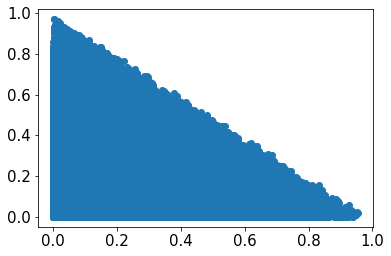

In [2]:
NumberofSources = 5
NumberofMixtures = 10
N = 500000
np.random.seed(0)
# https://stackoverflow.com/questions/65154622/sample-uniformly-at-random-from-a-simplex-in-python
S = np.random.exponential(scale=1.0, size=(NumberofSources,int(N)))
S = S / np.sum(S, axis = 0)

SNR=30
A = np.random.randn(NumberofMixtures,NumberofSources)
X = np.dot(A,S)

# X, NoisePart = addWGN(X, SNR, return_noise = True)

# SNRinp = 10 * np.log10(np.sum(np.mean((X - NoisePart)**2, axis = 1)) / np.sum(np.mean(NoisePart**2, axis = 1)))
print("The following is the mixture matrix A")
display_matrix(A)
# print("Input SNR is : {}".format(SNRinp))

plt.scatter(S[0,:], S[2,:])
plt.show()

In [3]:
MUS = 0.25
OUTPUT_COMP_TOL = 1e-5
MAX_OUT_ITERATIONS= 3000
LayerGains = [1,1]
LayerMinimumGains = [1,1]
LayerMaximumGains = [1e6,1.001]
WScalings = [0.0033,0.0033]
GamScalings = [0.01,0.01]
zeta = 1e-4
beta = 0.5
muD = [20, 1e-2]

s_dim = S.shape[0]
x_dim = X.shape[0]
h_dim = s_dim
samples = S.shape[1]
W_HX = np.eye(h_dim, x_dim)
W_YH = np.eye(s_dim, h_dim)

In [4]:
debug_iteration_point = 10000

model = OnlineWSMBSS(s_dim = s_dim, x_dim = x_dim, h_dim = h_dim, 
                     gamma_start = MUS, beta = beta, zeta = zeta, 
                     muD = muD,WScalings = WScalings,
                     W_HX = W_HX, W_YH = W_YH,
                     DScalings = LayerGains, LayerMinimumGains = LayerMinimumGains,
                     LayerMaximumGains = LayerMaximumGains,neural_OUTPUT_COMP_TOL = OUTPUT_COMP_TOL,
                     set_ground_truth = True, S = S, A = A)

In [5]:
neural_dynamic_iterations = 750
neural_lr_start = 0.5
neural_lr_stop = 0.5
stlambd_lr = 0.05
OUTPUT_COMP_TOL = 1e-5

W_HX = model.W_HX
W_YH = model.W_YH
M_H = model.M_H
M_Y = model.M_Y
D1 = model.D1
D2 = model.D2

In [6]:
np.random.seed(100)
H = np.zeros((h_dim,samples))
Y = np.zeros((s_dim,samples))

H = np.random.randn(h_dim,samples)#*0.05
Y = np.random.randn(s_dim,samples)#*0.05

i_sample = 287

x_current  = X[:,i_sample] # Take one input
y = Y[:,i_sample]
h = H[:,i_sample]

In [7]:
x_current

array([-0.83703761,  1.19661875, -1.40850573, -0.46339289, -0.12031191,
        0.43986206,  0.71996589,  0.42492308, -0.78919669,  0.69301288])

In [8]:
model.run_neural_dynamics_simplex_jit(x_current, h, y, M_H, M_Y, W_HX, W_YH, D1, D2, beta, zeta, 
                                        neural_dynamic_iterations, neural_lr_start, neural_lr_stop, 
                                      OUTPUT_COMP_TOL)

(array([-2.,  2., -2., -2.,  2.]),
 array([0.        , 0.50079481, 0.        , 0.        , 0.50079481]))

In [9]:
neural_dynamic_iterations = 10
neural_lr_start = 0.5
neural_lr_stop = 0.5
stlambd_lr = 0.05
OUTPUT_COMP_TOL = 1e-5

W_HX = model.W_HX
W_YH = model.W_YH
M_H = model.M_H
M_Y = model.M_Y
D1 = model.D1
D2 = model.D2

Gamma_H = np.diag(np.diag(M_H))
M_hat_H = M_H - Gamma_H

Gamma_Y = np.diag(np.diag(M_Y))
M_hat_Y = M_Y - Gamma_Y

In [10]:
np.random.seed(100)
H = np.random.randn(h_dim,samples)
Y = np.random.randn(s_dim,samples)
    
i_sample = 0

x_current  = X[:,i_sample] # Take one input
y = Y[:,i_sample]
h = H[:,i_sample]

In [11]:
x_current

array([-0.49714629,  1.24079097, -0.47421845, -0.27091309, -0.23725804,
        0.07902261,  0.6619771 ,  0.32515113, -0.64859556,  0.47434392])

In [17]:
np.random.seed(100)
W_HX = np.random.randn(*W_HX.shape)
W_YH = np.random.randn(*W_YH.shape)
M_H = np.random.randn(*M_H.shape)
M_Y = np.random.randn(*M_Y.shape)
Gamma_H = np.diag(np.diag(M_H))
M_hat_H = M_H - Gamma_H

Gamma_Y = np.diag(np.diag(M_Y))
M_hat_Y = M_Y - Gamma_Y
display_matrix(W_YH)
display_matrix(W_HX)
display_matrix(M_Y)
display_matrix(M_H)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [20]:
(1 - zeta) * beta * np.diag(np.diag(M_H @ D1 @ M_H - W_HX @ W_HX.T))

array([[-3.91303541,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -1.78062765,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -5.50000429,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -6.85610975,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -2.94631813]])

In [18]:
(1 - zeta) * beta * np.diag(np.diag(M_H @ D1 @ M_H - W_HX @ W_HX.T)) + zeta * model.dlogdet(D1)

array([[-3.91293541,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -1.78052765,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -5.49990429,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -6.85600975,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -2.94621813]])

In [19]:
(1 - zeta) * (1 - beta) * np.diag(np.diag(M_Y @ D2 @ M_Y - W_YH @ W_YH.T)) + zeta * model.dlogdet(D2)

array([[ 2.15909088,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -1.93263148,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.10749132,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.74644604,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -4.34437778]])

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [40]:
h

array([-1.74976547, -0.12773771,  0.53281181, -1.53948234, -1.87250186])

In [41]:
((1 - beta) * Gamma_H + beta * D1 @ Gamma_H @ D1) #@ h

array([[-0.55071441,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.68689007,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.02828363,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.37690335,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -2.48715154]])

In [42]:
y

array([ 0.57278576,  0.71134792,  0.29973427,  0.05541315, -0.26550242])

In [43]:
Gamma_Y @ D2 @ y

array([-0.97639993,  0.09420224, -0.12700193, -0.10850345,  0.06337884])

In [44]:
(1 - zeta) * beta * D1 @ W_HX @ x_current

array([ 0.33338907,  0.19602026,  1.32512095, -0.72239449,  0.18416097])

In [45]:
((1 - zeta) * (1 - beta) * M_hat_H + (1- zeta) * beta * D1 @ M_hat_H @ D1) @ h

array([ 0.38215879, -4.89334902,  2.3736152 ,  0.50736577,  0.29133673])

In [46]:
 (1 - zeta) * (1 - beta) * W_YH.T @ D2 @ y

array([-0.0762816 , -0.49288666,  0.27524043, -0.14343776, -0.8400824 ])

In [47]:
(1 - zeta) * beta * D1 @ W_HX @ x_current - ((1 - zeta) * (1 - beta) * M_hat_H + (1- zeta) * beta * D1 @ M_hat_H @ D1) @ h + (1 - zeta) * (1 - beta) * W_YH.T @ D2 @ y

array([-0.12505133,  4.59648261, -0.77325382, -1.37319802, -0.94725816])

In [48]:
np.diag(Gamma_H * ((1 - zeta) * (1 - beta) + (1 - zeta) * beta * D1 ** 2))

array([-0.55065934,  0.68682138,  0.02828081, -0.37686566, -2.48690282])

In [49]:
(M_hat_Y @ D2) #@ y

array([[ 0.        , -1.13626101, -2.97331547,  0.03331728, -0.24888867],
       [-0.45017644,  0.        ,  0.02221393,  0.31736798, -0.75241418],
       [-1.29639181,  0.09513944,  0.        , -1.18598356, -0.36546199],
       [-1.27102304,  1.58617094,  0.69339066,  0.        , -0.13480131],
       [-1.54061602,  2.04671397, -1.39699934, -1.09717198,  0.        ]])

In [50]:
(M_hat_Y @ D2) @ y

array([-1.63155468, -0.03384223, -0.64356556,  0.64391852,  0.09395648])

In [52]:
np.diag(Gamma_Y * ((1 - zeta) * (1 - beta) * D2 ** 2))

array([-0.85224037,  0.06620728, -0.21183636, -0.97894271, -0.1193445 ])

In [9]:
model.run_neural_dynamics_simplex_jit(x_current, h, y, M_H, M_Y, W_HX, W_YH, D1, D2, beta, zeta, 
                                        neural_dynamic_iterations, neural_lr_start, neural_lr_stop, 
                                      OUTPUT_COMP_TOL)

(array([ 2., -2.,  2.,  2., -2.]),
 array([      0.        , 1168641.92187922,       0.        ,
         124883.02704321, 1490785.34782497]))

In [10]:
np.diag(Gamma_H * ((1 - zeta) * (1 - beta) + (1 - zeta) * beta * D1 ** 2))

array([0.019998, 0.019998, 0.019998, 0.019998, 0.019998])

In [11]:
np.diag(Gamma_Y * (D2))

array([0.02, 0.02, 0.02, 0.02, 0.02])

In [12]:
(M_hat_Y @ D2)

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])